In [3]:
%run loading_data.ipynb

audio : 55
audio_only : 33
video : 44
texte : 55
texte_only : 33


#### chargement des données et des features

In [4]:
label_normalised_origin = pd.read_csv('./data/label_normalised.csv', sep=",", index_col=0, header=0)
label_normalised_origin = label_normalised_origin.drop('\t',axis=1)
label_normalised, noteurs_normalised  = transform_annotation(label_normalised_origin)

graded = label_normalised[(label_normalised['isRated'] == 1)].copy()

g_audio, g_audio_only = get_media_type(graded, noteurs_normalised, media='audio')

audio : 55
audio_only : 54


In [5]:
selected_features = ['SR','SNR','CONF','VBR','SCORE']
selected_columns = ['SCENE'] + selected_features
selected_y = 'mean'

audio_features = pd.read_csv('./data/silence_rolling_mean_new.csv', sep='§', engine='python', index_col=0, encoding='utf-8')

DF = pd.merge(audio_features[selected_columns], g_audio_only.drop('count',axis=1), 
              left_on='SCENE', right_on='doc').sort_values(by=['SCENE'])
DF.reset_index(drop=1, inplace=True)
DF.set_index('doc',inplace=True)

for c in selected_features:
    DF.loc[np.isnan(DF.loc[:,c]),c] = np.nanmean(DF.loc[:,c])

## Régression linéaire, leave on out

In [6]:
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

scaler = preprocessing.StandardScaler(with_mean=True, with_std=True, copy=True)
scaler.fit(DF[selected_features])
DF_scaled = pd.DataFrame(scaler.transform(DF[selected_features]), 
                         index = DF.index, columns = selected_features)
DF_scaled[selected_y] = DF[selected_y]

X = DF_scaled[selected_features].values
y = DF_scaled[selected_y].values
preds_test = np.zeros(len(X))

loo = LeaveOneOut()
loo.get_n_splits(X)

coefficients = np.zeros([len(X),len(selected_features)+1])
for i,(train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    reg = LinearRegression().fit(X_train, y_train)
    preds_test[i] = reg.predict(X_test)
    coefficients[i,:] = [reg.intercept_] + reg.coef_.tolist()

erreurs = y - preds_test
rmse_test = np.sqrt(np.mean(erreurs**2))
rmse_test

1.0566757563960487

#### sélection de la moyennes des coefficients

In [7]:
THETA = coefficients.mean(axis=0)
XX = np.concatenate([np.ones([1,len(X)]), X.T]).T
lasso_preds = np.dot(XX, THETA)
erreurs = y - lasso_preds
rmse_test = np.sqrt(np.mean(erreurs**2))

print(THETA)
print(rmse_test)

[ 0.28163746  0.05150939  0.0805899  -0.01813273 -0.18506554  0.3336484 ]
0.75560196653141


## Régression lasso, leave one out

In [18]:
from sklearn import linear_model
alpha = 0.07

coefficients = np.zeros([len(X),len(selected_features)+1])
for i,(train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lasso = linear_model.Lasso(alpha=alpha).fit(X_train, y_train)
    preds_test[i] = lasso.predict(X_test)
    coefficients[i,:] = [lasso.intercept_] + lasso.coef_.tolist()

erreurs = y - preds_test
rmse_test = np.sqrt(np.mean(erreurs**2))
rmse_test

0.8976313209497669

#### sélection des coéfficients médians

In [19]:
THETA = np.median(coefficients,axis=0)
XX = np.concatenate([np.ones([1,len(DF)]), X.T]).T
lasso_preds = np.dot(XX, THETA)
erreurs = y - lasso_preds
rmse_test = np.sqrt(np.mean(erreurs**2))

print(THETA)
print(rmse_test)

[ 0.28105392  0.          0.          0.         -0.10973743  0.27503983]
0.7670759365192996


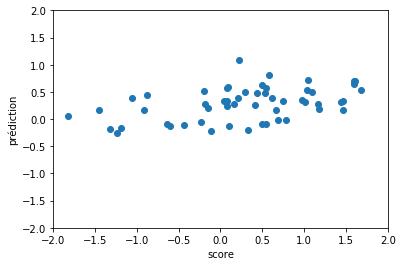

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.scatter(y, lasso_preds)
plt.xlabel("score")
plt.ylabel("prédiction")
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

In [11]:
from sklearn import linear_model
for alpha in np.array(range(1,20))/100:
    
    coefficients = np.zeros([len(X),len(selected_features)+1])
    for i,(train_index, test_index) in enumerate(loo.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lasso = linear_model.Lasso(alpha=alpha).fit(X_train, y_train)
        preds_test[i] = lasso.predict(X_test)
        coefficients[i,:] = [lasso.intercept_] + lasso.coef_.tolist()
    
    erreurs = y - preds_test
    rmse_test = np.sqrt(np.mean(erreurs**2))
    
    THETA = np.median(coefficients,axis=0)
    XX = np.concatenate([np.ones([1,len(DF)]), X.T]).T
    lasso_preds = np.dot(XX, THETA)
    erreurs = y - lasso_preds
    rmse_test = np.sqrt(np.mean(erreurs**2))
    
    print("alpha :",alpha,'\t\t rmse :',rmse_test)
    print(THETA)
    print()

alpha : 0.01 		 rmse : 0.7558756265272001
[ 0.28169419  0.03926466  0.07082358 -0.01007648 -0.17177557  0.3275514 ]

alpha : 0.02 		 rmse : 0.7567772616021256
[ 0.28144175  0.02756132  0.05745071 -0.00829923 -0.16039077  0.32000418]

alpha : 0.03 		 rmse : 0.758262935242989
[ 0.28167456  0.01606214  0.04408005 -0.00657372 -0.14909876  0.31245697]

alpha : 0.04 		 rmse : 0.7603410152837103
[ 0.28178266  0.00462904  0.03079489 -0.00454789 -0.13780675  0.30490976]

alpha : 0.05 		 rmse : 0.7626078566238548
[ 0.28148462  0.          0.01799293 -0.00233112 -0.12789063  0.29536126]

alpha : 0.06 		 rmse : 0.7650546648997865
[ 0.28123131  0.          0.00550203  0.         -0.11907114  0.28460189]

alpha : 0.07 		 rmse : 0.7670759365192996
[ 0.28105392  0.          0.          0.         -0.10973743  0.27503983]

alpha : 0.08 		 rmse : 0.7688547720864998
[ 0.28093799  0.          0.          0.         -0.10059879  0.26570726]

alpha : 0.09 		 rmse : 0.7708575360030869
[ 0.28082207  0.       

In [26]:
print("note moyenne dans l'audio only :",g_audio_only['mean'].mean())
print("note moyenne dans l'audio :",g_audio['mean'].mean())

np.mean(label_normalised.iloc[:,0:9])

note moyenne dans l'audio only : 0.2802260033716651
note moyenne dans l'audio : 0.025253785432488626


il08_09   -4.844610e-17
vg04_05   -8.679925e-17
fd03_04    1.069851e-16
la09_10    1.402918e-16
cg13_14    3.229740e-17
ja05_06   -2.330421e-17
fj11_12    3.179275e-17
ec20_11   -4.037175e-18
mb00_12   -8.881784e-17
dtype: float64